In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
#define constant
rnn_unit=10       #hidden layer units
input_size=6      
output_size=1
lr=0.0006    # learning rate
test_len=288 #test lenth
wind_data_raw = pd.read_csv('wind2012.csv',skiprows=3)
wind_data=wind_data_raw.iloc[:,5:12].values

In [2]:
def get_data(batch_size=168, time_step=12, train_begin=0, train_end=60000):
    # setting training set
    batch_index=[]
    # nomalize the data
    ## create the scaler from the wind data 
    train_scaler_1 = MinMaxScaler(feature_range=(0,1))
    ## apply the scaler transform to the wind data
    nor_wind_data = train_scaler_1.fit_transform(wind_data)
    train_data=nor_wind_data[train_begin:train_end]
    train_scaler = MinMaxScaler(feature_range=(0,1))
    m=train_scaler.fit_transform(wind_data[:, -1].reshape(-1, 1))
    ## define trainning set x and y
    train_x,train_y=[],[]
    for i in range(len(train_data)-time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x=train_data[i:i+time_step,:-1]
        y=train_data[i:i+time_step,-1,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(train_data)-time_step))
    # setting testing data
    test_data=nor_wind_data[train_end:(train_end+test_len)]
    size=test_len//time_step
    #size=(len(test_data)+time_step-1)//time_step  #samples number ####-1???
    test_x=[]                ###280 lenth
    test_y=test_data[:,-1]   ###288lenth
    for i in range(size):
        x=test_data[i*time_step:(i+1)*time_step,:-1]
        #y=test_data[i*time_step:(i+1)*time_step,-1]
        test_x.append(x.tolist())
        #test_y.extend(y)
    #test_x.append((test_data[(i+1)*time_step:,:-1]).tolist())
    #test_y.extend((normalized_test_data[(i+1)*time_step:,-1]).tolist())
    return batch_index, train_x, train_y, test_x, test_y, train_scaler
    

    
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
    

In [3]:
def lstm(X):
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [4]:
def train_lstm(batch_size=168,time_step=12,train_begin=0,train_end=60000):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y,test_x,test_y,train_scaler=get_data(batch_size,time_step,
                                                       train_begin,train_end)
    pred,_=lstm(X)
    #loss function
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    loss_data=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver.restore(sess, module_file)
        #trainning for specified times
        steps=20
        for i in range(steps):
            for step in range(len(batch_index)-2):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],
                                                            Y:train_y[batch_index[step]:batch_index[step+1]]})
            loss_data.append(loss_)
            print("Number of iterations:",i," loss:",loss_)

        print("The train has finished")
        
        #prediction
        test_predict=[]
        for step in range(len(test_x)):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_predict=np.array(test_predict).reshape(-1,1)
        test_y=np.array(test_y).reshape(-1,1)

      
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        
        test_predict=train_scaler.inverse_transform(test_predict).reshape(-1,1)
        test_y=train_scaler.inverse_transform(test_y).reshape(-1,1)
        #acc=np.average(np.abs(test_predict[:200]-test_y[:200])/test_y[:200])
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        #print('accuracy=', acc)
        print('rmse=',rmse,'   mae=',mae)
        plt.figure()
        plt.plot(list(range(len(test_predict))),test_predict,color='b')
        plt.plot(list(range(len(test_y))),test_y,color='r')
        plt.show()
        

Number of iterations: 0  loss: 0.005885223
Number of iterations: 1  loss: 0.002084223
Number of iterations: 2  loss: 0.0012431785
Number of iterations: 3  loss: 0.00080242957
Number of iterations: 4  loss: 0.00053806807
Number of iterations: 5  loss: 0.0003913973
Number of iterations: 6  loss: 0.00031291318
Number of iterations: 7  loss: 0.00026472393
Number of iterations: 8  loss: 0.00022825533
Number of iterations: 9  loss: 0.00020013847
Number of iterations: 10  loss: 0.00018050888
Number of iterations: 11  loss: 0.00016712623
Number of iterations: 12  loss: 0.00015585401
Number of iterations: 13  loss: 0.00014454828
Number of iterations: 14  loss: 0.00013430411
Number of iterations: 15  loss: 0.00012551186
Number of iterations: 16  loss: 0.0001174575
Number of iterations: 17  loss: 0.00011078889
Number of iterations: 18  loss: 0.000105914325
Number of iterations: 19  loss: 0.00010202456
The train has finished
rmse= 0.019062244608586115    mae= 0.014610874091999397


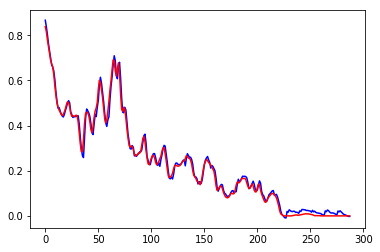

In [5]:
train_lstm()